In [102]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
from sklearn.decomposition import PCA
import numpy as np
import datetime
import os

from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
from models.vae import DenseVariationalAutoencoder, VariationalAutoencoder
#disable_eager_execution()

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

TRAINING_FRACTION = 0.8
N_DENSE = 2
L=16
NON_LINEAR_ACTIVATION_BOOL=True

In [103]:
# run params
SECTION = 'vae'
RUN_ID = '0003'
#DATA_NAME = 'digits'
DATA_NAME = 'xy'
RUN_FOLDER = '{}/run/{}/'.format(os.getcwd(), SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [104]:
user = 1
if user == 1:
    prefix_s3 = "/home/owen/"
    prefix_data = "/home/owen/repos/"
elif user == 2:
    prefix_data = "/Users/omyers/repos/"
    
tensorboard_log_dir = "{}/logs/fit/".format(prefix_s3) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [105]:
# Just do this so it is easier to configure arbitrary choices
work_with_t_list = [ "00.10", "00.20", "00.30", "00.40", "00.50", "00.60", "00.70", "00.80", "00.90", "01.00", "01.10", "01.20", "01.30", "01.40", "01.50", "01.60", "01.70", "01.80", "01.90", "02.00"]

In [106]:
df_bins = None
df_conf = None
for i, t_string in enumerate(work_with_t_list):
    bins_f_name = "{prefix_data}z3support/data/XYMLData/2DXY-configs-L-{l}/bins_2DXY-configs-L-{l}-{l}-{t}-0000.txt".format(
        l = str(L).zfill(4),
        t = t_string,
        prefix_data = prefix_data
    )
    configs_f_name = "{prefix_data}z3support/data/XYMLData/2DXY-configs-L-{l}/spinConfigs_2DXY-configs-L-{l}-{l}-{t}-0000.txt".format(
        l = str(L).zfill(4),
        t = t_string,
        prefix_data = prefix_data
    )
    if i == 0:
        df_bins = pd.read_csv(bins_f_name, sep="\t")
        df_conf = pd.read_csv(configs_f_name, delimiter=r"\s+", header=None)
    else:
        cur_df_bins = pd.read_csv(bins_f_name, sep="\t")
        cur_df_conf = pd.read_csv(configs_f_name, delimiter=r"\s+", header=None)
        df_bins = df_bins.append(cur_df_bins) 
        df_conf = df_conf.append(cur_df_conf) 
    print(bins_f_name)

/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0016/bins_2DXY-configs-L-0016-0016-00.10-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0016/bins_2DXY-configs-L-0016-0016-00.20-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0016/bins_2DXY-configs-L-0016-0016-00.30-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0016/bins_2DXY-configs-L-0016-0016-00.40-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0016/bins_2DXY-configs-L-0016-0016-00.50-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0016/bins_2DXY-configs-L-0016-0016-00.60-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0016/bins_2DXY-configs-L-0016-0016-00.70-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0016/bins_2DXY-configs-L-0016-0016-00.80-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0016/bins_2DXY-configs-L-0016-0016-00.90-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-

In [107]:
df_bins.shape

(200000, 10)

In [108]:
df_bins = df_bins.astype(
    {
        " T ": float,
        " binNum": int,
    }
)

In [109]:
df_conf["T"] = df_bins[" T "]

In [110]:
mean_col = df_conf[0].copy()
for i in range(1, L):
    mean_col += df_conf[i]

mean_col /= L

In [111]:
df_conf["M"] = mean_col

In [112]:
df_conf.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       248, 249, 250, 251, 252, 253, 254, 255, 'T', 'M'],
      dtype='object', length=258)

In [113]:
df_conf.shape

(200000, 258)

In [114]:
df_conf.head()

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,T,M
0,1.556908,1.700251,1.286740,1.333554,1.935889,1.392411,1.903922,1.781047,1.644003,1.456510,...,1.724801,1.794323,2.160901,2.016668,1.862466,2.099976,1.755041,2.080891,0.1,1.676787
1,0.449358,0.284169,0.110582,0.316963,0.309245,0.007220,0.132248,0.248091,6.199557,6.210290,...,0.113690,0.187911,0.381211,0.439792,0.533806,0.380159,6.243337,0.342518,0.1,0.998589
2,5.874689,5.861319,5.717695,5.349464,5.149222,5.051441,5.754105,5.572867,5.614452,5.757395,...,5.947179,5.673022,5.783555,5.720445,5.787259,5.683092,5.809804,5.735588,0.1,5.631094
3,0.579087,0.398948,0.059830,0.212079,0.207130,0.406396,0.264235,0.255291,0.622365,0.351162,...,0.847066,0.497288,0.783738,0.665467,0.731709,0.514824,0.226228,0.894068,0.1,0.421956
4,3.180521,3.118362,3.202986,3.077825,2.982245,3.182920,2.962104,2.911524,2.588305,2.857718,...,2.919455,3.058893,3.098180,2.882240,2.939362,3.138479,3.188607,3.699828,0.1,3.030602


In [115]:
cols = []
for i in range(L*L):
    cols.append(str(i))
    cols.append(str(i))
print(cols)

['0', '0', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', '10', '10', '11', '11', '12', '12', '13', '13', '14', '14', '15', '15', '16', '16', '17', '17', '18', '18', '19', '19', '20', '20', '21', '21', '22', '22', '23', '23', '24', '24', '25', '25', '26', '26', '27', '27', '28', '28', '29', '29', '30', '30', '31', '31', '32', '32', '33', '33', '34', '34', '35', '35', '36', '36', '37', '37', '38', '38', '39', '39', '40', '40', '41', '41', '42', '42', '43', '43', '44', '44', '45', '45', '46', '46', '47', '47', '48', '48', '49', '49', '50', '50', '51', '51', '52', '52', '53', '53', '54', '54', '55', '55', '56', '56', '57', '57', '58', '58', '59', '59', '60', '60', '61', '61', '62', '62', '63', '63', '64', '64', '65', '65', '66', '66', '67', '67', '68', '68', '69', '69', '70', '70', '71', '71', '72', '72', '73', '73', '74', '74', '75', '75', '76', '76', '77', '77', '78', '78', '79', '79', '80', '80', '81', '81', '82', '82', '83', '83', '84', '84',

In [116]:
xy_spec = ["x", "y"] * L*L

In [117]:
for i in zip(cols, xy_spec):
    continue
    #print(i)

In [118]:
np_angle_matrix = df_conf.drop(["T","M"], axis=1).to_numpy()

In [119]:
np_x_matrix = np.cos(np_angle_matrix)
np_y_matrix = np.sin(np_angle_matrix)

In [120]:
#np.concatenate(np_x_matrix, np_x_matrix, axis=1)
df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(zip(cols, xy_spec)))

In [121]:
df.sort_index(ascending=True, inplace=True, axis=1)

In [122]:
df.loc[:, (slice(None), slice("x"))] = np_x_matrix

In [123]:
np_x_matrix

array([[ 0.01388745, -0.12909381,  0.28025149, ..., -0.50482557,
        -0.18320417, -0.48826   ],
       [ 0.90072595,  0.95989501,  0.99389209, ...,  0.92860548,
         0.99920618,  0.94191198],
       [ 0.91771916,  0.91232647,  0.8443258 , ...,  0.82528289,
         0.89003206,  0.85377805],
       ...,
       [ 0.35518189,  0.86364036,  0.5413335 , ...,  0.82841878,
         0.73347829,  0.91677531],
       [-0.83796256, -0.91055089, -0.24791174, ...,  0.99678711,
         0.3697388 ,  0.26907025],
       [ 0.96818999, -0.76737471,  0.06265026, ..., -0.928166  ,
        -0.99514568,  0.3016261 ]])

In [124]:
np_y_matrix

array([[ 0.99990356,  0.99163239,  0.95992661, ...,  0.86322138,
         0.98307489,  0.87269822],
       [ 0.4343878 ,  0.28035972,  0.11035628, ...,  0.37106854,
        -0.03983736,  0.33585982],
       [-0.39722985, -0.40946358, -0.53583014, ..., -0.56471953,
        -0.45589795, -0.52063715],
       ...,
       [ 0.93479721,  0.50410845,  0.84080797, ..., -0.56010921,
         0.67971288,  0.39940334],
       [-0.54572773,  0.413397  , -0.96878262, ...,  0.0800965 ,
        -0.92913574, -0.96312055],
       [-0.25021621,  0.64119892,  0.99803554, ..., -0.37216647,
         0.09841277, -0.95342629]])

In [125]:
df.loc[:, (slice(None), "y")] = np_y_matrix

In [127]:
df

0                   1                  10                 100  \
               x         y         x         y         x         y         x   
0       0.013887  0.999904 -0.129094  0.991632  0.280251  0.959927  0.235024   
1       0.900726  0.434388  0.959895  0.280360  0.993892  0.110356  0.950186   
2       0.917719 -0.397230  0.912326 -0.409464  0.844326 -0.535830  0.594847   
3       0.836963  0.547260  0.921470  0.388449  0.998211  0.059795  0.977595   
4      -0.999242 -0.038918 -0.999730  0.023228 -0.998116 -0.061355 -0.997968   
...          ...       ...       ...       ...       ...       ...       ...   
199995  0.972849 -0.231441  0.094902  0.995487  0.995847  0.091043  0.866387   
199996  0.767148 -0.641470  0.935878  0.352324  0.734895  0.678181  0.112359   
199997  0.355182  0.934797  0.863640  0.504108  0.541334  0.840808 -0.274097   
199998 -0.837963 -0.545728 -0.910551  0.413397 -0.247912 -0.968783 -0.219128   
199999  0.968190 -0.250216 -0.767375  0.641199  0.062650  0.998036  0.963963   

                       101            ...        95                  96  \
               y         x         y  ...         x         y         x   
0       0.971990 -0.357036  0.934091  ... -0.431244  0.902235 -0.287552   
1       0.311682  0.952564  0.304340  ...  0.904840  0.425751  0.860877   
2      -0.803839  0.423072 -0.906096  ...  0.845796 -0.533506  0.879528   
3       0.210493  0.978625  0.205652  ...  0.786629  0.617426  0.744034   
4       0.063724 -0.987331  0.158675  ... -0.966556  0.256455 -0.979621   
...          ...       ...       ...  ...       ...       ...       ...   
199995 -0.499374  0.895477 -0.445107  ...  0.163646  0.986519  0.820065   
199996 -0.993668  0.164847  0.986319  ... -0.791902  0.610649 -0.706129   
199997 -0.961702 -0.473178 -0.880967  ...  0.532440 -0.846468  0.981438   
199998 -0.975696 -0.672153 -0.740412  ...  0.991617 -0.129213  0.570984   
199999 -0.266036  0.712408 -0.701765  ... -0.996632 -0.082003  0.876971   

                        97                  98                  99            
               y         x         y         x         y         x         y  
0       0.957765 -0.504826  0.863221 -0.183204  0.983075 -0.488260  0.872698  
1       0.508813  0.928605  0.371069  0.999206 -0.039837  0.941912  0.335860  
2      -0.475846  0.825283 -0.564720  0.890032 -0.455898  0.853778 -0.520637  
3       0.668142  0.870379  0.492381  0.974519  0.224304  0.626246  0.779625  
4       0.200855 -0.999995  0.003113 -0.998895 -0.046997 -0.848191 -0.529690  
...          ...       ...       ...       ...       ...       ...       ...  
199995  0.572270 -0.148309 -0.988941 -0.244211  0.969722 -0.786918 -0.617057  
199996 -0.708083 -0.961756  0.273906 -0.986207  0.165514 -0.932619  0.360862  
199997 -0.191778  0.828419 -0.560109  0.733478  0.679713  0.916775  0.399403  
199998 -0.820961  0.996787  0.080096  0.369739 -0.929136  0.269070 -0.963121  
199999 -0.480544 -0.928166 -0.372166 -0.995146  0.098413  0.301626 -0.953426  

[200000 rows x 512 columns]

In [128]:
train_with_meta_info = df.sample(frac=TRAINING_FRACTION, axis=0)
test_with_meta_info = df.drop(index=train_with_meta_info.index)
#train = train_with_meta_info.drop(["T","M"], axis=1)
#test = test_with_meta_info.drop(["T","M"], axis=1)
train = train_with_meta_info
test = test_with_meta_info

In [129]:
img_pca = PCA(n_components=N_DENSE)
img_pca.fit(train.to_numpy())

PCA(n_components=2)

In [130]:
components = img_pca.transform(df.to_numpy())

In [131]:
df.to_numpy().shape

(200000, 512)

In [132]:
components.shape

(200000, 2)

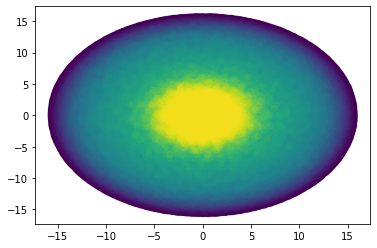

In [133]:
if N_DENSE > 1:
    plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(df_conf["T"]), alpha=0.1)

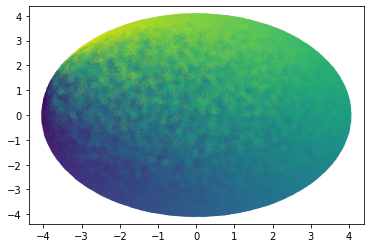

In [32]:
if N_DENSE > 1:
    plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(df_conf["M"]), alpha=0.1)

# Dense AE

In [33]:
simp_ae = tf.keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(L*L*2,)),
        keras.layers.Dense(N_DENSE, use_bias=False, name='latent_space'),
        keras.layers.Dense(L*L*2),
    ]
)

print(simp_ae.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent_space (Dense)        (None, 2)                 64        
                                                                 
 dense (Dense)               (None, 32)                96        
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________
None


2022-08-30 22:39:28.291916: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-30 22:39:28.291938: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: owen-PRIME-Z390-A
2022-08-30 22:39:28.291942: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: owen-PRIME-Z390-A
2022-08-30 22:39:28.291993: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.141.3
2022-08-30 22:39:28.292009: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.141.3
2022-08-30 22:39:28.292013: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.141.3
2022-08-30 22:39:28.292340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following

In [34]:
tb_callback = keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=0,  
    write_graph=True,
    write_images=True
)

simp_ae.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [35]:
simp_ae.fit(
    batch_size=16,
    x=train.to_numpy(),
    y=train.to_numpy(),
    epochs=20,
    callbacks=[tb_callback]
)

Epoch 1/20
10000/10000 [==============================] - 10s 934us/step - loss: 0.2000 - mae: 0.3347
Epoch 2/20
10000/10000 [==============================] - 9s 941us/step - loss: 0.1910 - mae: 0.3257
Epoch 3/20
10000/10000 [==============================] - 9s 922us/step - loss: 0.1910 - mae: 0.3257
Epoch 4/20
10000/10000 [==============================] - 8s 824us/step - loss: 0.1910 - mae: 0.3257
Epoch 5/20
10000/10000 [==============================] - 10s 1ms/step - loss: 0.1910 - mae: 0.3256
Epoch 6/20
10000/10000 [==============================] - 10s 1000us/step - loss: 0.1910 - mae: 0.3256
Epoch 7/20
10000/10000 [==============================] - 10s 1ms/step - loss: 0.1910 - mae: 0.3256
Epoch 8/20
10000/10000 [==============================] - 10s 972us/step - loss: 0.1910 - mae: 0.3256
Epoch 9/20
10000/10000 [==============================] - 10s 999us/step - loss: 0.1910 - mae: 0.3256
Epoch 10/20
10000/10000 [==============================] - 10s 973us/step - loss: 0.1910

In [36]:
mid_layer = simp_ae.get_layer('latent_space')

In [37]:
mid_layer.get_weights()[0].shape

(32, 2)

In [38]:
extractor = keras.Model(inputs=simp_ae.inputs,
                        outputs=[layer.output for layer in simp_ae.layers])

In [39]:
features = extractor(df.to_numpy())

In [40]:
features[0]

<tf.Tensor: shape=(200000, 2), dtype=float32, numpy=
array([[-1.3602887 , -0.29000616],
       [-0.12695111, -1.4134393 ],
       [ 1.1141955 ,  0.85279393],
       ...,
       [-0.58732355,  0.1996884 ],
       [-0.06488425,  0.6769451 ],
       [ 0.31997064,  0.16234165]], dtype=float32)>

In [41]:
features[0][:,0]

<tf.Tensor: shape=(200000,), dtype=float32, numpy=
array([-1.3602887 , -0.12695111,  1.1141955 , ..., -0.58732355,
       -0.06488425,  0.31997064], dtype=float32)>

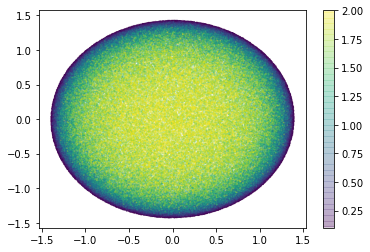

In [42]:
plt.scatter(features[0][:,0], features[0][:,1], c=df_conf["T"], s=0.5, alpha=0.2)
plt.colorbar()

# Dense VAE

In [134]:
x = train.to_numpy().reshape(-1,L*L*2)
x_test = test.to_numpy().reshape(-1,L*L*2)
x = x.astype(float)
x_test = x_test.astype(float)

In [135]:
print(x.shape)
print(x_test.shape)

(160000, 512)
(40000, 512)


In [136]:
print(type(x))
print(type(x_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [137]:
#x = x+10
#x_test = x_test+10

In [138]:
# Need to do this for VAE but cant have it on for the feature and scatter stuff for the normal AE above
disable_eager_execution()
vae = DenseVariationalAutoencoder(
    input_dim=(L*L*2,),
    encoder_layer_sizes=[L, 2],
    decoder_layer_sizes=[2, L, L*L*2],
    z_dim=N_DENSE,
    non_linear_activation_bool=NON_LINEAR_ACTIVATION_BOOL
)

In [139]:
LEARNING_RATE = 0.0005
#R_LOSS_FACTOR = 1000
R_LOSS_FACTOR = 1000

In [140]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [141]:
BATCH_SIZE = 16
EPOCHS = 10
PRINT_EVERY_N_BATCHES = 10
INITIAL_EPOCH = 0

In [142]:
#x.shape
#vae.encoder.summary()
vae.decoder.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_14 (Dense)            (None, 2)                 6         
                                                                 
 dense_15 (Dense)            (None, 2)                 6         
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 2)                 0         
                                                                 
 dense_16 (Dense)            (None, 16)                48        
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 512)               870

In [143]:
r = vae.train(     
    x,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    run_folder = RUN_FOLDER,
    print_every_n_batches = PRINT_EVERY_N_BATCHES,
    initial_epoch = INITIAL_EPOCH,
    #x_test=tf.data.Dataset.from_tensor_slices(x_test)
)

Train on 80000 samples, validate on 80000 samples
Epoch 1/10
 2816/80000 [>.............................] - ETA: 6s - loss: 663.9204 - vae_r_loss: 658.2345 - vae_kl_loss: 5.6858

2022-09-09 08:28:27.030256: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-09-09 08:28:27.030271: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-09-09 08:28:27.031278: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-09 08:28:27.032070: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-09-09 08:28:27.033121: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/owen/logs/fit/20220909-082826/plugins/profile/2022_09_09_08_28_27

2022-09-09 08:28:27.033621: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /home/owen/logs/fit/20220909-082826/plugins/profile/2022_09_09_08_28_27/owen-PRIME-Z390-A.trace.json.gz
2022-09-09 08:28:27.034891: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/owen/logs/fit/202

79104/80000 [============================>.] - ETA: 0s - loss: 464.2444 - vae_r_loss: 460.1113 - vae_kl_loss: 4.1323

/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


80000/80000 [==============================] - 7s 90us/sample - loss: 464.0209 - vae_r_loss: 459.8878 - vae_kl_loss: 4.1324 - val_loss: 441.1307 - val_vae_r_loss: 437.2855 - val_vae_kl_loss: 3.8453
Epoch 2/10
80000/80000 [==============================] - 8s 95us/sample - loss: 430.7236 - vae_r_loss: 426.2941 - vae_kl_loss: 4.4296 - val_loss: 417.4788 - val_vae_r_loss: 413.1828 - val_vae_kl_loss: 4.2962
Epoch 3/10
80000/80000 [==============================] - 7s 91us/sample - loss: 410.9474 - vae_r_loss: 406.8632 - vae_kl_loss: 4.0840 - val_loss: 409.4465 - val_vae_r_loss: 405.3836 - val_vae_kl_loss: 4.0636
Epoch 4/10
80000/80000 [==============================] - 8s 101us/sample - loss: 407.9124 - vae_r_loss: 403.9467 - vae_kl_loss: 3.9659 - val_loss: 408.5603 - val_vae_r_loss: 404.5970 - val_vae_kl_loss: 3.9637
Epoch 5/10
80000/80000 [==============================] - 8s 104us/sample - loss: 407.2788 - vae_r_loss: 403.4167 - vae_kl_loss: 3.8614 - val_loss: 408.0489 - val_vae_r_loss:

/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


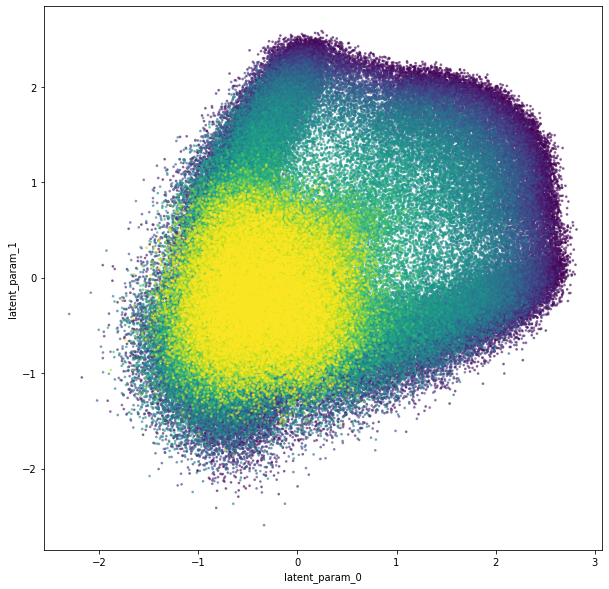

In [144]:
figsize = 10

z_points = vae.encoder.predict(df.to_numpy())

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
#plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.scatter(z_points[:, 0] , z_points[:, 1], c=df_conf['T'], alpha=0.5, s=3)
plt.xlabel("latent_param_0")
plt.ylabel("latent_param_1")
plt.show()



# Convolutional VAE

In [145]:
train

0                   1                  10                 100  \
               x         y         x         y         x         y         x   
17500   0.421369 -0.906889  0.518312 -0.855191  0.323538 -0.946215  0.315423   
47728   0.081180  0.996699 -0.347291  0.937757 -0.333003  0.942926 -0.244804   
114836 -0.236217  0.971700  0.322852  0.946450  0.113401  0.993549 -0.432054   
147469 -0.343343 -0.939210  0.124625  0.992204  0.175886  0.984411 -0.392664   
157773 -0.997141 -0.075570 -0.292208 -0.956355  0.802748 -0.596318  0.845072   
...          ...       ...       ...       ...       ...       ...       ...   
148543 -0.603847 -0.797100  0.014764 -0.999891  0.774024 -0.633156  0.411148   
39866   0.968307 -0.249765  0.979153  0.203126  0.988565  0.150796  0.960840   
10225   0.722485 -0.691386  0.883349 -0.468715  0.960269 -0.279075  0.957470   
176274  0.341723 -0.939801  0.152524  0.988300  0.887743  0.460340  0.446989   
20501  -0.989140 -0.146979 -0.794381 -0.607420 -0.923185 -0.384355 -0.998208   

                       101            ...        95                  96  \
               y         x         y  ...         x         y         x   
17500  -0.948951  0.132693 -0.991157  ...  0.413620 -0.910450  0.615380   
47728   0.969573  0.115747  0.993279  ... -0.947342  0.320224 -0.500357   
114836  0.901848  0.982615  0.185657  ...  0.797034 -0.603934  0.768071   
147469  0.919682 -0.983542 -0.180677  ... -0.658758  0.752355  0.231418   
157773 -0.534653  0.619722 -0.784822  ... -0.212667  0.977125 -0.134236   
...          ...       ...       ...  ...       ...       ...       ...   
148543 -0.911568  0.019368 -0.999812  ... -0.024561 -0.999698 -0.862907   
39866   0.277103  0.981881  0.189499  ...  0.981929  0.189249  0.977744   
10225  -0.288533  0.948799 -0.315881  ...  0.913495 -0.406850  0.705932   
176274  0.894540  0.831792  0.555087  ... -0.919414 -0.393292 -0.832038   
20501  -0.059835 -0.908134 -0.418679  ... -0.764502 -0.644621 -0.991789   

                        97                  98                  99            
               y         x         y         x         y         x         y  
17500  -0.788231  0.460296 -0.887766  0.717767 -0.696283  0.718934 -0.695078  
47728   0.865819 -0.081996  0.996633  0.447650  0.894209 -0.883677  0.468097  
114836  0.640365  0.191745  0.981445  0.985349  0.170549  0.958161  0.286229  
147469 -0.972854  0.510882 -0.859651 -0.975409 -0.220404 -0.953866 -0.300233  
157773  0.990949  0.139252 -0.990257 -0.997552 -0.069931 -0.064612  0.997910  
...          ...       ...       ...       ...       ...       ...       ...  
148543 -0.505363 -0.995402 -0.095781 -0.626223 -0.779644 -0.999267  0.038284  
39866   0.209802  0.975204  0.221307  0.657218  0.753700  0.959358  0.282192  
10225  -0.708279  0.880953 -0.473204  0.675002 -0.737816  0.993252 -0.115977  
176274 -0.554719  0.703856 -0.710343  0.991258  0.131936  0.008276  0.999966  
20501  -0.127885 -0.997034 -0.076957 -0.945173  0.326570 -0.945340  0.326087  

[160000 rows x 512 columns]

In [146]:
x = train.to_numpy().reshape(-1,L,L,2)
x_test = test.to_numpy().reshape(-1,L,L,2)

In [147]:
conv_vae = VariationalAutoencoder(
    input_dim = (L,L,2)
    , encoder_conv_filters = [8,8,16]
    , encoder_conv_kernel_size = [3,3,3]
    , encoder_conv_strides = [1,2,1]
    , decoder_conv_t_filters = [16,8,1]
    , decoder_conv_t_kernel_size = [3,3,3]
    , decoder_conv_t_strides = [1,2,1]
    , z_dim = 2
)

In [148]:
CONV_LEARNING_RATE = 0.0005
CONV_R_LOSS_FACTOR = 1000

In [149]:
conv_vae.compile(CONV_LEARNING_RATE, CONV_R_LOSS_FACTOR)

In [150]:
conv_vae.encoder.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 16, 16, 2)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 16, 16, 8)    152         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu_20 (LeakyReLU)     (None, 16, 16, 8)    0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 8, 8, 8)      584         ['leaky_re_lu_20[0][0]']         
                                                                                           

In [155]:
CONV_BATCH_SIZE = 16
CONV_EPOCHS = 10
CONV_PRINT_EVERY_N_BATCHES = 100
CONV_INITIAL_EPOCH = 0

In [156]:
conv_vae.train(     
    x
    , batch_size = CONV_BATCH_SIZE
    , epochs = CONV_EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = CONV_PRINT_EVERY_N_BATCHES
    , initial_epoch = CONV_INITIAL_EPOCH
)

Train on 160000 samples
Epoch 1/10
   816/160000 [..............................] - ETA: 31s - loss: 445.6168 - vae_r_loss: 443.1136 - vae_kl_loss: 2.5032

2022-09-09 08:48:35.866345: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-09-09 08:48:35.866361: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-09-09 08:48:35.869620: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-09 08:48:35.870162: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-09-09 08:48:35.871188: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/owen/logs/fit/20220909-084835/plugins/profile/2022_09_09_08_48_35

2022-09-09 08:48:35.871623: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /home/owen/logs/fit/20220909-084835/plugins/profile/2022_09_09_08_48_35/owen-PRIME-Z390-A.trace.json.gz
2022-09-09 08:48:35.872361: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/owen/logs/fit/202

159808/160000 [============================>.] - ETA: 0s - loss: 451.9815 - vae_r_loss: 449.4861 - vae_kl_loss: 2.4941
Epoch 1: saving model to /home/owen/repos/z3support/notebooks/run/vae/0003_xy/weights/weights-001-451.98.h5

Epoch 1: saving model to /home/owen/repos/z3support/notebooks/run/vae/0003_xy/weights/weights.h5
160000/160000 [==============================] - 28s 177us/sample - loss: 451.9799 - vae_r_loss: 449.4846 - vae_kl_loss: 2.4942 - lr: 5.0000e-04
Epoch 2/10
159904/160000 [============================>.] - ETA: 0s - loss: 451.9642 - vae_r_loss: 449.4608 - vae_kl_loss: 2.5035
Epoch 2: saving model to /home/owen/repos/z3support/notebooks/run/vae/0003_xy/weights/weights-002-451.96.h5

Epoch 2: saving model to /home/owen/repos/z3support/notebooks/run/vae/0003_xy/weights/weights.h5
160000/160000 [==============================] - 28s 177us/sample - loss: 451.9580 - vae_r_loss: 449.4546 - vae_kl_loss: 2.5035 - lr: 5.0000e-04
Epoch 3/10
160000/160000 [=======================

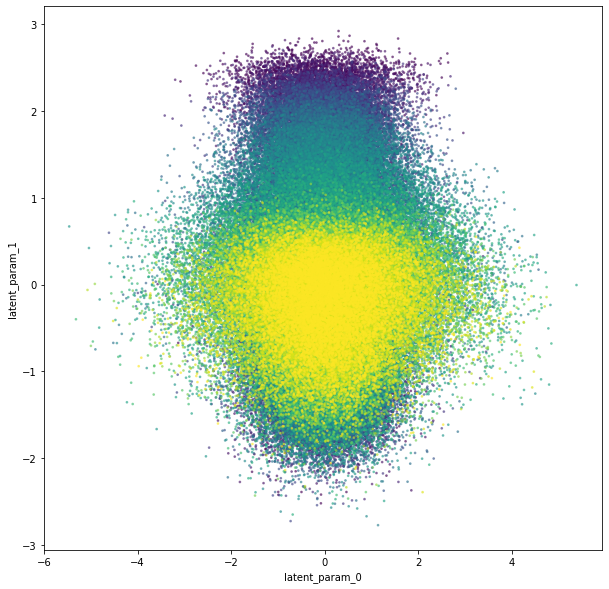

In [158]:
figsize = 10

z_points = conv_vae.encoder.predict(df.to_numpy().reshape(-1,L,L,2))

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
#plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.scatter(z_points[:, 0] , z_points[:, 1], c=df_conf['T'], alpha=0.5, s=3)
plt.xlabel("latent_param_0")
plt.ylabel("latent_param_1")
plt.show()



In [100]:
#df_conf#.filter(items=test.index,axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,T,M
0,0.162246,5.973095,6.133531,6.156717,0.025063,6.050038,6.020508,6.223365,0.067779,6.153401,6.032560,0.073008,6.134114,6.160847,0.052111,0.115091,0.1,4.606397
1,4.983357,4.822849,4.691446,4.885390,5.122919,4.853683,4.793827,4.921220,4.869675,5.132625,5.236716,4.908288,4.935758,4.859949,4.700985,5.001698,0.1,4.845760
2,2.727240,2.390374,2.708473,2.618912,2.354293,2.384652,2.535973,2.779869,2.592872,2.413333,2.715683,2.716086,2.763101,2.847251,2.660584,2.721994,0.1,2.611250
3,5.762936,5.839879,0.023180,6.216394,6.118754,6.144861,0.033664,0.032085,6.282960,0.085963,0.031738,0.152408,6.027732,6.234099,0.083261,0.023046,0.1,4.460597
4,4.463147,4.564015,4.342138,4.595675,4.269949,4.323170,4.407668,4.411044,4.368104,4.413393,4.490482,4.530060,4.503687,4.435605,4.239925,4.452277,0.1,4.491244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.961475,1.120173,3.015277,2.859901,2.462753,2.679678,2.562129,2.602867,2.938824,3.958659,4.160392,2.777843,2.834264,4.521152,2.697978,1.350121,2.0,2.239206
9996,0.927484,2.693284,4.823525,1.834211,6.002589,5.645381,3.207167,4.518647,5.060423,5.677578,0.403435,5.751913,1.318353,2.530393,4.150466,1.381927,2.0,2.569626
9997,3.083439,1.528634,0.451843,0.193794,3.808864,0.592086,0.642117,0.565445,1.159416,0.645269,0.918636,5.468957,5.592771,4.934163,2.095211,5.710414,2.0,1.314428
9998,0.596467,2.204761,2.766275,0.787203,5.765027,0.611504,2.502742,2.034828,3.014334,1.091611,2.908084,2.321281,2.603204,0.203233,6.219547,1.086780,2.0,1.588676


# No XY Transform Convolutional VAE

In [154]:
np_angle_matrix 

array([[1.55690843, 1.70025141, 1.28674023, ..., 2.09997621, 1.75504112,
        2.08089115],
       [0.44935849, 0.28416884, 0.11058151, ..., 0.38015945, 6.2433374 ,
        0.34251793],
       [5.87468896, 5.8613193 , 5.71769467, ..., 5.68309194, 5.80980446,
        5.73558826],
       ...,
       [1.20768768, 0.52834934, 0.99877405, ..., 5.68866769, 0.74737111,
        0.41086593],
       [3.71884998, 2.71541102, 4.46186487, ..., 0.08018239, 5.09111687,
        4.98481653],
       [6.03028175, 2.44553304, 1.50810501, ..., 3.52293472, 3.04302033,
        5.01878671]])

In [ ]:
no_transform_train = df_conf.drop(["T","M"], axis=1).to_numpy()

In [157]:
train_with_meta_info = df_conf.sample(frac=TRAINING_FRACTION, axis=0)
test_with_meta_info = df_conf.drop(index=train_with_meta_info.index)
train = train_with_meta_info.drop(["T","M"], axis=1)
test = test_with_meta_info.drop(["T","M"], axis=1)

x = train.to_numpy().reshape(-1,L,L,1)
x_test = test.to_numpy().reshape(-1,L,L,1)

In [159]:
conv_vae_2 = VariationalAutoencoder(
    input_dim = (L,L,1)
    , encoder_conv_filters = [8,8,16]
    , encoder_conv_kernel_size = [3,3,3]
    , encoder_conv_strides = [1,2,1]
    , decoder_conv_t_filters = [16,8,1]
    , decoder_conv_t_kernel_size = [3,3,3]
    , decoder_conv_t_strides = [1,2,1]
    , z_dim = 2
)

In [160]:
CONV_2_BATCH_SIZE = 16
CONV_2_EPOCHS = 5
CONV_2_PRINT_EVERY_N_BATCHES = 100
CONV_2_INITIAL_EPOCH = 0

In [162]:
CONV_2_LEARNING_RATE = 0.0005
CONV_2_R_LOSS_FACTOR = 1000

In [165]:
conv_vae_2.compile(CONV_2_LEARNING_RATE, CONV_2_R_LOSS_FACTOR)

In [166]:
conv_vae_2.train(     
    x
    , batch_size = CONV_2_BATCH_SIZE
    , epochs = CONV_2_EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = CONV_2_PRINT_EVERY_N_BATCHES
    , initial_epoch = CONV_2_INITIAL_EPOCH
)

Train on 160000 samples
Epoch 1/5
   864/160000 [..............................] - ETA: 1:15 - loss: 9622.8351 - vae_r_loss: 9479.7900 - vae_kl_loss: 143.0446

2022-09-09 09:00:29.848615: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-09-09 09:00:29.848630: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-09-09 09:00:29.851905: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-09 09:00:29.852638: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-09-09 09:00:29.853580: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/owen/logs/fit/20220909-090028/plugins/profile/2022_09_09_09_00_29

2022-09-09 09:00:29.854140: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /home/owen/logs/fit/20220909-090028/plugins/profile/2022_09_09_09_00_29/owen-PRIME-Z390-A.trace.json.gz
2022-09-09 09:00:29.855303: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/owen/logs/fit/202

159744/160000 [============================>.] - ETA: 0s - loss: 7889.8683 - vae_r_loss: 7887.8159 - vae_kl_loss: 2.0596
Epoch 1: saving model to /home/owen/repos/z3support/notebooks/run/vae/0003_xy/weights/weights-001-7889.27.h5

Epoch 1: saving model to /home/owen/repos/z3support/notebooks/run/vae/0003_xy/weights/weights.h5
160000/160000 [==============================] - 29s 181us/sample - loss: 7889.2704 - vae_r_loss: 7887.2192 - vae_kl_loss: 2.0563 - lr: 5.0000e-04
Epoch 2/5
159792/160000 [============================>.] - ETA: 0s - loss: 7877.7004 - vae_r_loss: 7877.6899 - vae_kl_loss: 1.9683e-04
Epoch 2: saving model to /home/owen/repos/z3support/notebooks/run/vae/0003_xy/weights/weights-002-7877.99.h5

Epoch 2: saving model to /home/owen/repos/z3support/notebooks/run/vae/0003_xy/weights/weights.h5
160000/160000 [==============================] - 28s 176us/sample - loss: 7877.9866 - vae_r_loss: 7877.9761 - vae_kl_loss: 1.9661e-04 - lr: 5.0000e-04
Epoch 3/5
159888/160000 [=======

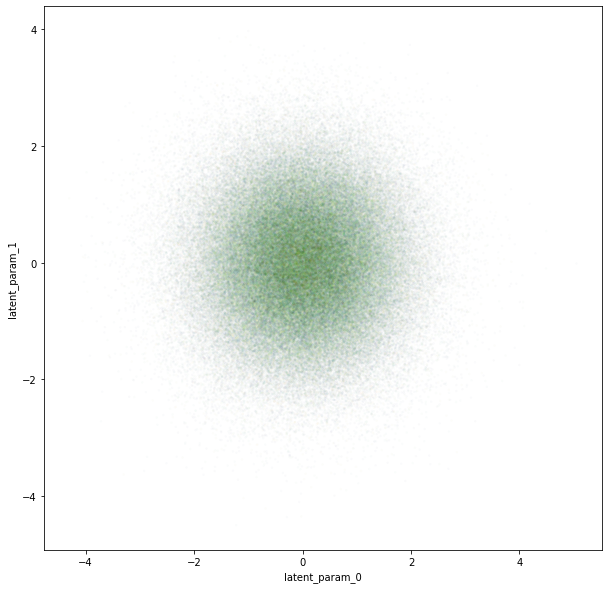

In [171]:
figsize = 10

z_points = conv_vae_2.encoder.predict(df_conf.drop(["T","M"], axis=1).to_numpy().reshape(-1,L,L,1))

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
#plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.scatter(z_points[:, 0] , z_points[:, 1], c=df_conf['T'], alpha=0.01, s=3)
plt.xlabel("latent_param_0")
plt.ylabel("latent_param_1")
plt.show()

